<a href="https://colab.research.google.com/github/Rogerio-mack/Machine-Learning-I/blob/main/ML4_Knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="Universidade Presbiteriana Mackenzie">
</head>

<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg" width=300, align="right">
<!-- <h1 align=left><font size = 6, style="color:rgb(200,0,0)"> optional title </font></h1> -->


# **4. Classificação: Knn**
---

Nesta aula você vai aprender sobre:

* Outras Métricas de Classificação: Matriz de Confusão, Precisão, Revocação, F1
* Como empregar essas métricas para comparar e selecionar melhores modelos
* Modelos de K-Vizinhos mais Próximos para Classificação



Na aula anterior concluímos observando que a métrica de acuracidade é uma medida de desempenho dos modelos bastante geral e que pode levar a erro de avaliação dos modelos (modelos com alta acuracidade ainda assim podem ser ruins). Nesta aula vamos explorar um pouco mais esse problema e introduzir algumas outras métricas que irão melhor permitir avaliarmos os modelos. Você conhecerá as Métricas de Classificação: **Precisão, Revocação, F1 e a Matriz de Confusão**. 

Essas métricas são bastante importantes e são empregadas tanto para comparar e selecionar melhores modelos entre os diferentes modelos que podemos implementar, mas também são empregados para o ajuste de parâmetros dos modelos (e que chamaremos de hiperparâmetros). 

Você também vai aprender aqui como funciona e como implementar um modelo de **K-Vizinhos mais Próximos para Classificação**, um novo modelo de classificação e poderermos comparar o seu resultado com os que obtivemos antes com o classificador logístico.

# Acuracidade

Vamos retomar nosso exemplo de Moons e então analisar mais de perto os resultados com novas métricas de classificação.

## Recriando os dados de *Moons*

Vamos recriar nosso conjunto de dados para classificação mas agora construindo um conjunto de dados mais complexo. Vamos aproveitar que sabemos que a regressão logística é um separador linear para *dificultarmos* a classificação empregando um conjunto de dados não separável linearmente. Com isso teremos a oportunidade de analisar melhor outras métricas de classificação.

In [219]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import seaborn as sns

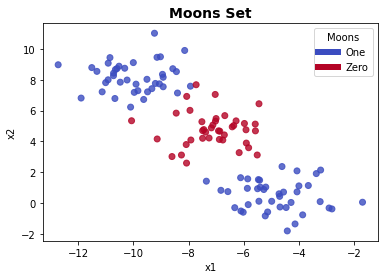

         x1        x2  y
0 -5.422578  1.477418  0
1 -5.270181  0.872708  0
2 -2.800484 -0.387307  0
3 -8.064956  6.915338  1
4 -6.111296  1.640534  0


In [220]:
from sklearn.datasets import make_moons, make_blobs
cmap_data = plt.cm.coolwarm 

X, y = make_blobs(n_samples=120, n_features=2, random_state=12) 
df = pd.DataFrame({'x1':X[:, 0], 'x2':X[:, 1], 'y':y})
df.y = df.y.replace(1,2)
df.y = df.y.replace(0,1)
df.y = df.y.replace(2,0)

plt.scatter(df.x1, df.x2, c=df.y, cmap=cmap_data, alpha=0.8)
plt.title('Moons Set',weight='bold',fontsize=14)
plt.xlabel("x1")
plt.ylabel("x2")

custom_lines = [Line2D([0], [0], color=cmap_data(0.), lw=6),
                Line2D([0], [0], color=cmap_data(1.), lw=6)]
plt.legend(custom_lines, ['One', 'Zero'], loc='upper right',title='Moons')

plt.show()

print(df.head())

In [221]:
df.y.value_counts()

0    80
1    40
Name: y, dtype: int64

## Aplicação do Classificador Logístico

Vamos agora aplicar o classificador Logístico que você já conhece empregando 0.3 dos dados para teste.

In [222]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split

X = df[['x1','x2']]
y = df.y

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

clf = LogisticRegression(max_iter=1000)

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print( y_pred[0:10], '...' )
print( f'{clf.score(X_test,y_test):.2f}' )


[1 0 0 0 0 0 0 0 0 0] ...
0.69


Você obtêm, então, um resultado com 69% de acuracidade, com 11 erros de classificação sobre o conjunto de teste. Nada mal, afinal são quase 70%  de acerto! Você certamente apostaria em qualquer coisa com chance de 70%.

In [223]:
sum(y_test != y_pred)

11

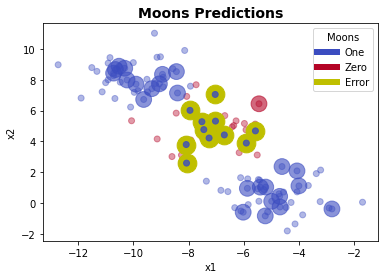

In [224]:
cmap_data = plt.cm.coolwarm 

plt.scatter(X.x1, X.x2, c=y, cmap=cmap_data, alpha=0.4) # todos dados
plt.scatter(X_test.x1, X_test.x2, c=y_pred, s=250,cmap=cmap_data, alpha=0.6) # somente dados de teste

plt.scatter(X_test[y_pred != y_test].x1, X_test[y_pred != y_test].x2, color='y', s=350, alpha=1, label='wrong predictions')
plt.scatter(X_test[y_pred != y_test].x1, X_test[y_pred != y_test].x2, c=y_test[y_pred != y_test], cmap=cmap_data, alpha=0.8)
plt.title('Moons Predictions',weight='bold',fontsize=14)
plt.xlabel("x1")
plt.ylabel("x2")

custom_lines = [Line2D([0], [0], color=cmap_data(0.), lw=6),
                Line2D([0], [0], color=cmap_data(1.), lw=6),
                Line2D([0], [0], color='y', lw=6)]
plt.legend(custom_lines, ['One', 'Zero', 'Error'], loc='upper right',title='Moons')

plt.show()



Esse resultado não parece muito bom, mas você já esperava por isso: a regressão logística não consegue separar perfeitamente classes que não sejam linearmente separáveis!

Mas valores muito altos de acuracidade não iriam permitir explorarmos melhor outras métricas que você verá a seguir.

# Matriz de Confusão e Classification Report

O resultado de 0.69 não parece ruim à primeira vista. Mas bom ou ruim, a ideia é que esse resultado pode não estar distribuído uniformemente entre as classes, e você pode rever o último exemplo da aula anterior. Pode haver uma classe que tenha um resultado de classificação muito bom e outra um resultado muito ruim. Esse valor da acuracidade é um valor geral, média do resultado de todas as classes. Esse é apenas um dos resultados que podemos buscar com outras métricas de classificação.

Várias dessas métricas podem ser obtidas diretamente o scikit-learn como abaixo, e você vai ver em detalhe cada uma delas. Os valores de Acuracidade (1) e (2) são os mesmos, e apenas empregam métodos diferentes. 



In [225]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, y_pred)
print('\nMatriz de Confusão:\n')
print(cm)
    
accuracy = accuracy_score(y_test, y_pred)
print('\nScore de Acuracidade (1):\n')
print(f'{accuracy:.2f}')

accuracy = clf.score(X_test, y_test)
print('\nScore de Acuracidade (2):\n')
print(f'{accuracy:.2f}')

print('\nClassification Report:\n')
print(classification_report(y_test, y_pred))


Matriz de Confusão:

[[24  0]
 [11  1]]

Score de Acuracidade (1):

0.69

Score de Acuracidade (2):

0.69

Classification Report:

              precision    recall  f1-score   support

           0       0.69      1.00      0.81        24
           1       1.00      0.08      0.15        12

    accuracy                           0.69        36
   macro avg       0.84      0.54      0.48        36
weighted avg       0.79      0.69      0.59        36



## Matriz de Confusão

Certamente poderíamos construir uma tabela como abaixo, com os valores do conjunto de teste e as classes *reais* `y` e os valores previstos `y_pred` e analisar os resultados.




In [226]:
results = pd.concat([ X_test,y_test], axis=1)
results['y_pred'] = y_pred
results['Igual?'] =  y_pred == y_test
results

,x1,x2,y,y_pred,Igual?
34,-5.445509,6.437457,1,1,True
43,-4.610938,2.364080,0,0,True
23,-8.071103,2.587660,1,0,False
35,-5.866169,0.949079,0,0,True
44,-5.904228,3.887125,1,0,False
101,-4.067622,2.082736,0,0,True
11,-6.701767,4.416635,1,0,False
50,-9.328387,7.418267,0,0,True
10,-5.200051,1.031011,0,0,True
100,-10.715177,8.424962,0,0,True


A coluna `Igual?` traz se a predição corresponde ou não ao valor esperado. Ao final, é sobre esse resultado que são produzidas todas as métricas, mas ao invés de empregarmos esses dados *brutos* para análise vamos empregar funções que já trazem resultados mais sumarizados. Afinal, acima são apenas 36 casos e duas classes, mas poderíamos estar lidando com milhares de casos e dezenas de classes, e o uso de uma tabela como acima seria iria requerer um grande esforço para análise.

A matriz de confusão é uma matriz que sumariza os resultados de acertos e erros do modelo para avaliar o desempenho da classificação. É uma matriz quadrada, $n \times n$  onde $n$ é o número de classes objetivo. Lembrando que avaliamos o modelo sobre os resultados no conjunto de teste, a matriz compara os valores reais (conjunto de teste) com aqueles estimados pelo modelo do mesmo modo que nossa tabela acima com a coluna `Igual?`, mas trazendo a informação de modo bastante mais sumarizado. 

Ela permite uma visão mais ampla do desempenho do modelo, que a simples medida de acuracidade, pois permite identificar os tipos de erros que o modelo está cometendo.

Em problema de classificação binária, como no nosso exemplo anterior, a matriz de confusão é uma matriz $2 \times 2$ com o seguinte formato:

![imagem](https://github.com/Rogerio-mack/Machine-Learning-I/raw/main/Figures/matriz_de_confusao.png) 

Onde as linhas representam os dados de teste e as colunas os valores previstos. Vamos explorar essa matriz.

> **Na Matriz de Confusão as linhas representam os dados de teste e as colunas os valores previstos. Vale a pena você se deter um pouco sobre isso e de fato entender os valores em cada linha e coluna da Matriz de Confusão.**

Isso em geral traz uma certa *confusão* nos alunos (desculpem o trocadilho! rs), pois poderíamos ter adotado uma ordem diferente, com os dados de teste nas linhas e os valores previstos nas colunas. Essa ordem de fato aparece em muitas referências pois sua interpretação permanece a mesma independentemente da ordem escolhida. Por  que então escolhemos  as linhas para representar os dados de teste e as colunas os valores previstos? Por que as funções do scikit-learn em geral têm esse padrão e adotaremos essa ordem nas análises e interpretações.  

> **Cuidado: A ordem dos dados de teste e predições, em linhas ou colunas, pode ser qualquer em uma Matriz de Confusão. Por que escolhemos  as linhas para representar os dados de teste e as colunas os valores previstos? Por que as funções do scikit-learn em geral têm esse padrão e adotaremos essa ordem nas análises e interpretações.**


Outro ponto é a ordem dos rótulos ou valores. A ordem dos labels, se não especificada será a ordem alfabética. Se consideramos '1' o caso positivo pode ser interessantes colocarmos a ordem [1,0] para nossos propósitos.


Veja abaixo algumas explorações da Matriz de Confusão neste caso simples. Procure entender de fato como ela funciona!

In [227]:
cm = confusion_matrix(y_test, y_pred, labels=[1,0])
print('\nMatriz de Confusão:\n')

print('\t\t\t    y_pred \n')
print('\t\t\t 0 \t 1')
print('\t\t' + 29*'-')
print('\t\t  0  | \t ' + str(cm[1,1]) + '\t' + str(cm[1,0]) + '    |  ' + str(cm[1,0] + cm[1,1]))
print('      y_test  \t  1  | \t ' + str(cm[0,1]) + '\t' + str(cm[0,0]) + '    |  ' + str(cm[0,0] + cm[0,1]))

print('\t\t' + 29*'-')
print('\t\t     | \t ' + str(cm[0,1] + cm[1,1]) + '\t' + str(cm[0,0] + cm[1,0]) + '   |  ')




Matriz de Confusão:

			    y_pred 

			 0 	 1
		-----------------------------
		  0  | 	 24	0    |  24
      y_test  	  1  | 	 11	1    |  12
		-----------------------------
		     | 	 35	1   |  


É um bom exercício para entender essa matriz verificar alguns de seus valores, como por exemplo a soma das linhas e colunas: 

In [228]:
print( (y_test == 1).sum(), (y_test == 0).sum() )
print( (y_pred == 1).sum(), (y_pred == 0).sum() )

12 24
1 35


De fato 12, 24 (soma das linhas) correspondem às quantidades de elementos reais classes 1 e 0 em `y_test`.

In [229]:
y_test.value_counts()

0    24
1    12
Name: y, dtype: int64

Já os valores 1  e 35 (soma das colunas) correspondem às quantidades de elementos previstos nas classes 1 e 0 em `y_pred`. 



In [230]:
np.unique(y_pred, return_counts=True)

(array([0, 1]), array([35,  1]))

E você ainda pode verificar as instâncias classificadas corretamente para cada classe, que são os elementos da diagonal em que coincidem das classes reais e previstas pelo modelo.

In [231]:
print( ( y_test + y_pred == 2 ).sum() ) # ambos 1
print( ( y_test + y_pred == 0 ).sum() ) # ambos 0

1
24


Dessa matriz saem todos os valores e métricas úteis para a análise dos resultados. Particularmente nos interessam os valores: 

* **Verdadeiro positivo (TP)**, em que valor previsto corresponde ao valor real, isto é o valor real era positivo e o modelo previu um valor positivo

* **Verdadeiro negativo (TN)**, em que o valor real era negativo e o modelo previu um valor negativo também corretamente

* **Falso Positivo (FP)**, Ou **Erro Tipo 1**, em que o valor real era negativo, mas o modelo previu um valor positivo. É o caso em que o modelo é **superestimado**, gerando falsos alarmes.

* **Falso negativo (FN)**, Ou **Erro tipo 2**, em que o valor real era positivo, mas o modelo previu um valor negativo. É o caso em que o modelo é **substimado**, gerando perda de casos positivos.



In [232]:
cm = confusion_matrix(y_test, y_pred, labels=[1,0])
print('\nMatriz de Confusão:\n')

print('\t\t\t    y_pred \n')
print('\t\t\t 0 \t 1')
print('\t\t' + 29*'-')
print('\t\t  0  | \t ' + 'TP=' + str(cm[1,1]) + '\t' + 'FN=' + str(cm[1,0]) + '    |  ' + str(cm[1,0] + cm[1,1]))
print('      y_test  \t  1  | \t ' + 'FP=' + str(cm[0,1]) + '\t' + 'TN=' + str(cm[0,0]) + '    |  ' + str(cm[0,0] + cm[0,1]))

print('\t\t' + 29*'-')
print('\t\t     | \t ' + str(cm[0,1] + cm[1,1]) + '\t' + str(cm[0,0] + cm[1,0]) + '       |  ')


Matriz de Confusão:

			    y_pred 

			 0 	 1
		-----------------------------
		  0  | 	 TP=24	FN=0    |  24
      y_test  	  1  | 	 FP=11	TN=1    |  12
		-----------------------------
		     | 	 35	1       |  


Esses valores já permitem você identificar que nosso modelo não tem a mesma eficiência para as duas classes. 

Nosso modelo é superestimado, ele prevê muito mais casos positivos do que na realidade acontecem. Ele previu com sucesso 100% dos casos positivo, isto é, não há nenhum falso negativo ou *erro tipo 2*. Entretanto, sendo superestimado, produz um grande número (a maior parte, ou 11 em cada 12 casos) falsos positivos, ou *erro tipo 1*. 

Por exemplo, se 0 (positivo) representa pacientes com diagnóstico positivo para uma doença, nosso detecta corretamente 100% dos casos da doença, mas gera um número muito grande de falsos positivos e não serviria, portanto, para ser empregado em um exame (embora o erro tipo 2, não detectar os casos positivos fosse, no caso de doenças ainda mais grave). Desse modo, você pode concluir que nosso modelo, que não parecia tão ruim à primeira vista, é de fato um modelo que não pode ser empregado. 

Dessas medidas  $TP+FP+TN+FN$ se derivam dezenas de métricas de eficiência dos modelos. Nos deteremos aqui apenas nas mais importantes e você pode consultar https://en.wikipedia.org/wiki/Confusion_matrix para muitas outras métricas.

## Acuracidade

Você já conhece essa métrica e apenas vamos verificar que, como outras métricas, ela pode ser obtida diretamente da matriz de confusão: 

$$ Accuracy = \frac{TP+TN}{TP+FP+TN+FN} $$

Note que $TP+TN$ é a soma dos valores diagonais, ou o total de acertos, e $TP+FP+TN+FN$ é simplesmente a soma de todos valores, ou o total de casos.

$$ Accuracy = \frac{Total de Acertos}{Total de Casos} $$

In [233]:
cm = confusion_matrix(y_test, y_pred)
print('\nMatriz de Confusão:\n')
print(cm)

TP, FP, FN, TN = cm.T.ravel()
print('\nTP = ', TP, '\nFP = ', FP, '\nFN = ', FN, '\nTN = ', TN)


Matriz de Confusão:

[[24  0]
 [11  1]]

TP =  24 
FP =  11 
FN =  0 
TN =  1


In [234]:
Accuracy = (TP+TN)/(TP+FP+TN+FN)
print(f'{Accuracy:.2f}')

0.69


## Precisão e *Recall*

Outras duas métricas importante são a Precisão e o *Recall*,

$$ Precision = \frac{TP}{TP + FP} $$

e

$$ Recall = \frac{TP}{TP + FN} $$


Mas o que de fato essas métricas nos dizem? Você dificilmente irá guardar essas fórmulas. Mas é mais importante, e talvez até mais fácil, entender o conceito por trás dessas métricas o que já nos dá um modo direto de calcular os seus valores. 

A Precisão é um valor que, dados todos elementos previstos uma classe, quantos foram previstos corretamente. Isto é, o percentual dos casos que de fato pertencem àquela classe. No nosso exemplo, 69% são de fato positivos e, portanto, 31% são valores FP.

O *Recall* (Revocação, ou Sensibilidade) por outro lado nos diz quantos casos de uma determinada classe foram corretamente previstos. E você pode pensar que precisamos fazer uma nova busca (*recall*) para os elementos da classe que ainda não foram identificados! No nosso exemplo, 100% dos casos positivos foram corretamente identificados.


In [235]:
Precision = TP/(TP + FP)
print(f'{Precision:.2f}')

0.69


In [236]:
Recall = TP/(TP + FN)
print(f'{Recall:.2f}')

1.00


Esses mesmos valores você pode observar no `classification_report` do `scikit-learn`.  Os valores acima são os valores para a classe 0 (o caso positivo), sendo a primeira classe da matriz de confusão e do `classification_report`. Se você quiser trocar a classe positiva pode empregar o parâmetro `labels` em ambas as funções. 

A última métrica é o F1-score que pode ser entendido como uma média harmônica dos valores de precisão e recall:

$$ F1-score = \frac{2}{1/Recall + 1/Precision}$$

Na prática, quando tentamos aumentar a precisão do nosso modelo, o recall diminui e vice-versa. A pontuação F1 permite capturar ambas as tendências em um único valor e, por isso é bastante empregada sendo seu valor máximo quando a precisão e o recall são iguais.




In [237]:
F1_score = 2 / ( (1/Recall) + (1/Precision) )
print(f'{F1_score:.2f}')

0.81


## Classification Report

Todos  conceitos acima são importantes para entendermos as métricas, mas todas essas métricas são mais facilmente obtidas no `classification_report`.

In [238]:
print('\nClassification Report:\n')
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       0.69      1.00      0.81        24
           1       1.00      0.08      0.15        12

    accuracy                           0.69        36
   macro avg       0.84      0.54      0.48        36
weighted avg       0.79      0.69      0.59        36



Além das métricas que já discutimos você encontra os valores de suporte, que nada mais são que as quantidades de casos de cada classe. Esse valor é importante para identificarmos classes desbalanceadas e são empregados para o cálculo das médias ponderadas das métricas `weighted avg`. O `macro avg`, por outro lado, é apenas a média das métricas de todas as classes de dados. 

# CASO: 10 year risk of coronary heart disease CHD

Vamos revisitar o exemplo da aula anterior em que previmos um paciente com 10 anos de risco de futura doença cardíaca coronariana (ACS) e analisar melhor os resultados obtidos. Nossa variável objetivo aqui é `TenYearCHD`, *10 year risk of coronary heart disease CHD* (onde “1”, significa “Yes”, “0” significa “No”)


In [239]:
df = pd.read_csv('https://raw.githubusercontent.com/TarekDib03/Analytics/master/Week3%20-%20Logistic%20Regression/Data/framingham.csv')
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## Preparação dos Dados



Vamos, como antes, simplesmente excluir os dados ausentes.

In [240]:
print('Before',len(df))
df = df.dropna()
print('After',len(df))

Before 4240
After 3658


## Aplicando o Modelo Logístico

Aplicamos o modelo ajustando agora as entradas `X` e `y` para o modelo. O `max_iter` do regressor também foi ajustado para $10000$ uma vez que o conjunto de dados agora é maior e um maior número de iterações será necessário para convergência do parâmetros.

In [265]:
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split

X = df.drop(columns=['TenYearCHD'])
y = df.TenYearCHD

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

clf = LogisticRegression(max_iter=10000)

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print( y_pred[0:10], '...' )
print( f'{clf.score(X_test,y_test):.2f}' )

[0 0 1 0 0 0 0 0 0 0] ...
0.85


In [242]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, y_pred)
print('\nMatriz de Confusão:\n')
print(cm)
    
accuracy = accuracy_score(y_test, y_pred)
print('\nScore de Acuracidade (1):\n')
print(f'{accuracy:.2f}')

accuracy = clf.score(X_test, y_test)
print('\nScore de Acuracidade (2):\n')
print(f'{accuracy:.2f}')

print('\nClassification Report:\n')
print(classification_report(y_test, y_pred))


Matriz de Confusão:

[[921  10]
 [153  14]]

Score de Acuracidade (1):

0.85

Score de Acuracidade (2):

0.85

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.99      0.92       931
           1       0.58      0.08      0.15       167

    accuracy                           0.85      1098
   macro avg       0.72      0.54      0.53      1098
weighted avg       0.82      0.85      0.80      1098



## Análise 

Como você pode ver, apesar da acuracidade de $0.85$ do nosso modelo, ele acerta apenas pouco mais que uma moeda ($0.5$ é são as chances de cara ou coroa),  $0.56$, dos casos positivos de doença. Além disso apenas 0.08 dos casos de doença foram identificados pelo modelo. Esses dois valores se refletem também baixo F1-score médio desse modelo. Este é, portanto, um péssimo modelo se o objetivo é identificar pacientes em risco!








Como você viu na aula anterior (reveja o exemplo de *Acuracidade: Cuidado e Outras Métricas*), dados com classes desbalanceadas como esse (são somente 167 elementos da classe 1 para 931 casos da classe 0) são bastante comuns e há casos até bastante mais desbalanceados, com 1/100 ou 2/100, como casos de *churn de clientes*, *fraude de transações* ou mesmo diagnósticos de doenças graves. Em todos eles é uma felicidade que a classe de maior risco seja realmente bastante menor. Mas para o aprendizado de máquina isso é um grande problema pois permite atingirmos facilmente uma acuracidade geral alta apesar do mal desempenho do modelo.

# Métricas: Seleção de Modelos e Parâmetros

Modelos diferentes empregam princípios diferentes para fazerem as predições e geram, portanto, predições diferentes. Você pode imaginar, por exemplo, que para estimar um valor (modelos de regressão) você pode empregar um modelo linear ou exponencial, fórmulas que vão aproximar de modo diferente os dados e o mesmo ocorre nos modelos de classificação. 

Havendo predições diferentes, diferem também as métricas obtidas por cada modelo em um conjunto de dados e elas podem, então, serem empregadas para avaliar dois ou mais modelos que competem ou para ajustar parâmetros de um dado modelo.

A seguir você vai aprender outros modelos de classificação e poderá ver como empregar essas métricas na Seleção de Modelos e Parâmetros.



# K-Vizinhos Mais Próximos

O K-Vizinhos mais Próximos, ou Knn (do inglês, K nearest neighbors) é um dos modelos mais simples de classificação, mas também bastante empregado. Seu funcionamento se baseia em um princípio muito simples que nós mesmos adotamos frequentemente no dia a dia, nós, por exemplo, nos assemelhamos às pessoas mais próximas de nós. Assim, é razoável supor que podemos classificar uma instância de acordo com a classe de seus vizinhos mais próximos.

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_distance_metric.py:14: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  category=FutureWarning,


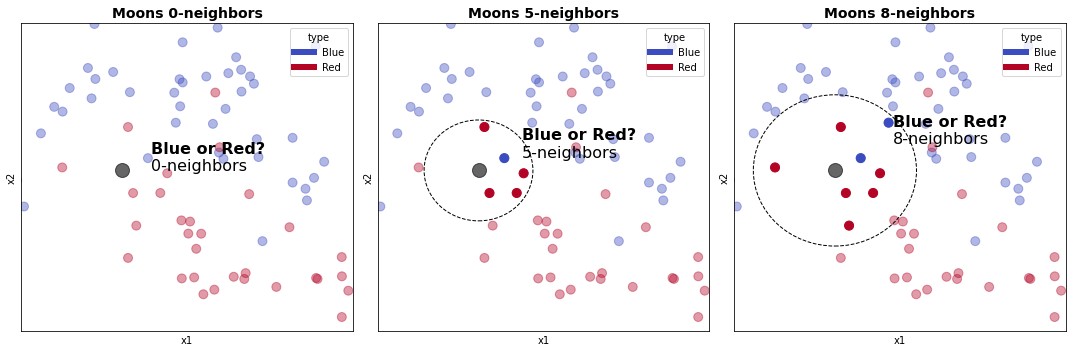

In [243]:
# you can skip this code!

from sklearn.datasets import make_moons
from sklearn.neighbors import DistanceMetric
cmap_data = plt.cm.coolwarm 

X, y = make_moons(n_samples=100, noise=0.25, random_state=1234)
moons = pd.DataFrame({'x1':X[:, 0], 'x2':X[:, 1], 'y':y})

X, y = make_moons(n_samples=1, noise=0.25, random_state=123)
# amoon = pd.DataFrame({'x1':X[:, 0], 'x2':X[:, 1], 'y':y})
amoon = pd.DataFrame({'x1':[-.2], 'x2':[.3]})

dist = DistanceMetric.get_metric('euclidean')
moons['distance'] = dist.pairwise(moons[['x1','x2']],amoon[['x1','x2']])

f, ax = plt.subplots(1,3,figsize=(15,5))
cmap_data = plt.cm.coolwarm 

for i in range(3):
  neighbors = moons.nsmallest([0,5,8][i],'distance')
  ax[i].scatter(moons.x1, moons.x2, c=moons.y, cmap=cmap_data, alpha=0.4, s=80)
  ax[i].scatter(neighbors.x1, neighbors.x2, c=neighbors.y, cmap=cmap_data, s=80)
  ax[i].plot(amoon.x1, amoon.x2, 'ko', markersize=14, alpha=0.6)

  a_circle = plt.Circle((amoon.x1, amoon.x2), neighbors.distance.max()+0.05, edgecolor='k', linestyle='dashed',fill=False)
  ax[i].add_artist(a_circle)

  ax[i].text(amoon.x1+0.2+i/10, amoon.x2+i/10,'Blue or Red?\n', weight='bold', fontsize=16)
  ax[i].text(amoon.x1+0.2+i/10, amoon.x2+i/10,' \n' + str([0,5,8][i]) + '-neighbors', fontsize=16)
  ax[i].set_title('Moons ' + str([0,5,8][i]) + '-neighbors',weight='bold',fontsize=14)
  ax[i].set_xlabel("x1")
  ax[i].set_ylabel("x2")

  custom_lines = [Line2D([0], [0], color=cmap_data(0.), lw=6),
                  Line2D([0], [0], color=cmap_data(1.), lw=6)]
  ax[i].legend(custom_lines, ['Blue', 'Red'], loc='upper right',title='type')

  ax[i].set_xlim([-0.9,1.4])
  ax[i].set_ylim([-0.9,1.4])
  ax[i].set_xticks([])
  ax[i].set_yticks([])
  # ax[i].axis('equal')

plt.tight_layout()
plt.show()


O número k define quantos vizinhos queremos empregar na classificação. No exemplo acima, considerando 5 vizinhos, você pode verificar que há uma chance de $4/5$ de que a moon *cinza* seja uma moon *red*, e com 8 vizinhos a chance é de $6/8 = 3/4$ de ser *red*. Assim, assumimos nos dois casos a classe *red* para prever a classe do ponto selecionado.

## Knn *by scratch*

O conceito do Knn é bastante simples o que permite implementar o algoritmo e verificar o seu funcionamento sem qualquer API ou pacote adicional. Basicamente o modelo consiste na execução de 3 passos:

1. Calcular as distâncias do elemento desejado para os demais
2. Encontrar os k-vizinhos mais próximos
3. Retornar a classe mais frequente entre dos k-vizinhos 

O exemplo a seguir é um *exemplo de brinquedo* e foi livremente adaptado de [Sayad (2021)](https://www.saedsayad.com/data_mining_map.htm). A ideia é prever, com base na  idade, valor e retorno de empréstimos realizados anteriormente, a possibilidade de fazermos um bom ou mal empréstimo para um novo caso que desejamos avaliar. 

In [244]:
loans = pd.DataFrame({'age':[25,35,45,20,35,52,23,40,60,48,33],
                      'loan':[40000,60000,80000,20000,120000,18000,95000,62000,100000,220000,150000],
                      'default':[1,1,1,1,1,1,0,0,0,0,0] }) # 1='yes'

case  = pd.DataFrame({'age':[47],'loan':[142000]})

display(loans)
display(case)

,age,loan,default
0,25,40000,1
1,35,60000,1
2,45,80000,1
3,20,20000,1
4,35,120000,1
5,52,18000,1
6,23,95000,0
7,40,62000,0
8,60,100000,0
9,48,220000,0


,age,loan
0,47,142000


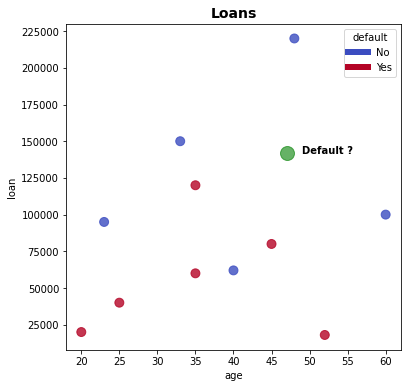

In [245]:
f, ax = plt.subplots(1,1,figsize=(6,6))
cmap_data = plt.cm.coolwarm 

ax.scatter(loans.age, loans.loan, c=loans.default, cmap=cmap_data, alpha=0.8, s=80)
ax.plot(case.age, case.loan, 'go', markersize=14, alpha=0.6)

plt.text(case.age+2, case.loan,'Default ?', weight='bold')
plt.title('Loans',weight='bold',fontsize=14)
plt.xlabel("age")
plt.ylabel("loan")

custom_lines = [Line2D([0], [0], color=cmap_data(0.), lw=6),
                Line2D([0], [0], color=cmap_data(1.), lw=6)]
plt.legend(custom_lines, ['No', 'Yes'], loc='upper right',title='default')

plt.show()


*Default* representa os casos em que o empréstimo não foi pago e, portanto, uma operação ruim. E nosso objetivo é prever, com base no conjunto de treinamento, qual classe (*Default Yes* ou *No*) de um novo empréstimo de $142.000$ para um cliente com $47$ anos.

Você pode, então, calcular diretamente a distância do par $(47, 142.000)$ para todos os demais dados e, na sequência, ordenar os dados para identificar os k-vizinhos mais próximos e a classe mais frenquente dentre eles. Aqui empregamos $k=3$ vizinhos mais próximos.

In [246]:
from sklearn.neighbors import DistanceMetric

dist = DistanceMetric.get_metric('euclidean')
d = dist.pairwise(loans[['age','loan']],case[['age','loan']])

loans['distance'] = d
display(loans.sort_values('distance'))

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_distance_metric.py:14: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  category=FutureWarning,


,age,loan,default,distance
10,33,150000,0,8000.012250
4,35,120000,1,22000.003273
8,60,100000,0,42000.002012
6,23,95000,0,47000.006128
2,45,80000,1,62000.000032
9,48,220000,0,78000.000006
7,40,62000,0,80000.000306
1,35,60000,1,82000.000878
0,25,40000,1,102000.002373
3,20,20000,1,122000.002988


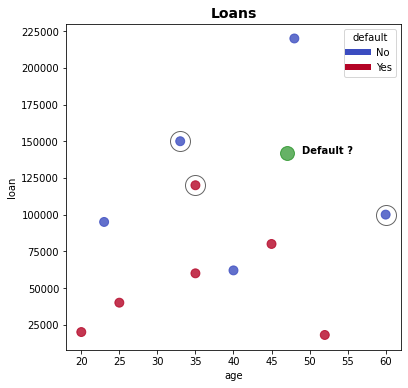

,age,loan,default,distance
10,33,150000,0,8000.012250
4,35,120000,1,22000.003273
8,60,100000,0,42000.002012


In [247]:
k3_neighbors = loans.nsmallest(3,'distance')

f, ax = plt.subplots(1,1,figsize=(6,6))
cmap_data = plt.cm.coolwarm 

ax.scatter(k3_neighbors.age, k3_neighbors.loan, edgecolors='k', c='w', alpha=0.6, s=400)
ax.scatter(loans.age, loans.loan, c=loans.default, cmap=cmap_data, alpha=0.8, s=80)
ax.plot(case.age, case.loan, 'go', markersize=14, alpha=0.6)

plt.text(case.age+2, case.loan,'Default ?', weight='bold')
plt.title('Loans',weight='bold',fontsize=14)
plt.xlabel("age")
plt.ylabel("loan")

custom_lines = [Line2D([0], [0], color=cmap_data(0.), lw=6),
                Line2D([0], [0], color=cmap_data(1.), lw=6)]
plt.legend(custom_lines, ['No', 'Yes'], loc='upper right',title='default')

plt.show()

display(k3_neighbors)

Com base nisso podemos estimar que a classe desse empréstimo é *Default No* (zeros) com probabilidade de $2/3$ e, portanto, deveríamos conceder o empréstimo.  

## Revisando o Modelo: Normalizando os Dados

O cálculo de distâncias como medida de similaridade (menor distância indicando maior similaridade) pode, entretanto, apresentar grandes desvios quando empregamos variáveis ​com escalas muito diferentes ou variáveis ​​numéricas e categóricas em conjunto.

Veja que no nosso exemplo os valores dos empréstimos encontram-se em uma escala de valores $1000$ vezes maior que a idade e, por isso, idade teve pouca ou nenhuma influência nas distâncias e poderíamos ter o mesmo resultado empregando somente o os valores dos empréstimos. 

> **Vários modelos de aprendizado de máquina são baseados em distância como medida de similaridade e são portanto *sensíveis* à normalização dos dados e devemos aplicá-la quando empregados dados em diferentes escalas.**
 

In [248]:
dist = DistanceMetric.get_metric('euclidean')
d = dist.pairwise(loans[['loan']],case[['loan']])

loans['distance_loans'] = d
display(loans.sort_values('distance'))

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_distance_metric.py:14: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  category=FutureWarning,


,age,loan,default,distance,distance_loans
10,33,150000,0,8000.012250,8000.0
4,35,120000,1,22000.003273,22000.0
8,60,100000,0,42000.002012,42000.0
6,23,95000,0,47000.006128,47000.0
2,45,80000,1,62000.000032,62000.0
9,48,220000,0,78000.000006,78000.0
7,40,62000,0,80000.000306,80000.0
1,35,60000,1,82000.000878,82000.0
0,25,40000,1,102000.002373,102000.0
3,20,20000,1,122000.002988,122000.0


A maior escala dos valores de `loan` faz com que o '*peso*' dessa variável no cálculo das distâncias praticamente '*anule*' a importância da variável *age*.

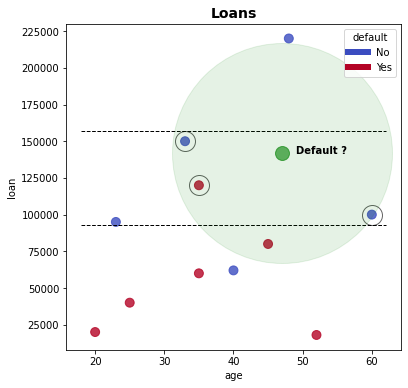

,age,loan,default,distance
10,33,150000,0,8000.012250
4,35,120000,1,22000.003273
8,60,100000,0,42000.002012


In [249]:
f, ax = plt.subplots(1,1,figsize=(6,6))
cmap_data = plt.cm.coolwarm 

ax.plot(case.age, case.loan, 'go', markersize=220, alpha=0.10)
ax.scatter(k3_neighbors.age, k3_neighbors.loan, edgecolors='k', c='w', alpha=0.6, s=400)
ax.scatter(loans.age, loans.loan, c=loans.default, cmap=cmap_data, alpha=0.8, s=80)
ax.plot(case.age, case.loan, 'go', markersize=14, alpha=0.6)

plt.hlines(157000,18,62,linestyles='dashed',lw=1)
plt.hlines(93000,18,62,linestyles='dashed',lw=1)

plt.text(case.age+2, case.loan,'Default ?', weight='bold')
plt.title('Loans',weight='bold',fontsize=14)
plt.xlabel("age")
plt.ylabel("loan")

custom_lines = [Line2D([0], [0], color=cmap_data(0.), lw=6),
                Line2D([0], [0], color=cmap_data(1.), lw=6)]
plt.legend(custom_lines, ['No', 'Yes'], loc='upper right',title='default')

plt.show()

display(k3_neighbors)

 A solução é normalizar os dados do conjunto de treinamento. Existem várias técnicas de normalização e aqui vamos empregar a normalização *min_max* que leva todos os valores ao intervalo $[0,1]$. 	

# Normalização com `scikit-learn`: Função *vs* Estimador

Você pode simplesmente empregar uma função `minmax_scale` do `scikit-learn` para fazer a normalização e existem outras funções para os demais tipos de normalização.

In [250]:
from sklearn.preprocessing import minmax_scale

minmax_scale(loans[['age','loan']])

array([[0.125     , 0.10891089],
       [0.375     , 0.20792079],
       [0.625     , 0.30693069],
       [0.        , 0.00990099],
       [0.375     , 0.5049505 ],
       [0.8       , 0.        ],
       [0.075     , 0.38118812],
       [0.5       , 0.21782178],
       [1.        , 0.40594059],
       [0.7       , 1.        ],
       [0.325     , 0.65346535]])

Mas o uso de funções não permite aplicarmos a mesma regra de normalização em outros conjuntos de dados!

In [251]:
minmax_scale(case)

array([[0., 0.]])

Neste caso, é melhor empregarmos um *estimador* do `scikit-learn`. O cálculo é o mesmo da função `minmaxscaler`, mas o uso de um estimador permite salvarmos os parâmetros empregados para a mesma aplicação em outros conjuntos de dados.

> *Na normalização de dados com o `scikit-learn` é preferível uso de estimadores no lugar de funções para que a mesma transformação possa ser efetuada em outros conjuntos de dados. O mesmo princípio se aplica a outras transformações, como os encodes.*

Vamos então aplicar o estimador `MinMaxScaler` no lugar da função.

In [252]:
# apenas mostrando o resultado do estimador
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
print(scaler.fit(loans[['age','loan']]))

print(scaler.data_max_)

print(scaler.transform(loans[['age','loan']]))
print(scaler.transform(case))

MinMaxScaler()
[6.0e+01 2.2e+05]
[[0.125      0.10891089]
 [0.375      0.20792079]
 [0.625      0.30693069]
 [0.         0.00990099]
 [0.375      0.5049505 ]
 [0.8        0.        ]
 [0.075      0.38118812]
 [0.5        0.21782178]
 [1.         0.40594059]
 [0.7        1.        ]
 [0.325      0.65346535]]
[[0.675      0.61386139]]


In [253]:
# criando os dados normalizados, 'scaled'
loans_scaled = pd.DataFrame(scaler.transform(loans[['age','loan']]),columns=loans.columns[0:2])
loans_scaled = pd.concat([loans_scaled,loans[['default']]],axis=1)
display(loans_scaled)

case_scaled = pd.DataFrame(scaler.transform(case),columns=case.columns[0:2])
display(case_scaled)

,age,loan,default
0,0.125,0.108911,1
1,0.375,0.207921,1
2,0.625,0.306931,1
3,0.000,0.009901,1
4,0.375,0.504950,1
5,0.800,0.000000,1
6,0.075,0.381188,0
7,0.500,0.217822,0
8,1.000,0.405941,0
9,0.700,1.000000,0


,age,loan
0,0.675,0.613861


Podemos agora refazer o cálculo das distância empregando os dados normalizados e identificar os k-vizinhos mais próximos e a classe mais frenquente dentre eles. 

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_distance_metric.py:14: FutureWarning: sklearn.neighbors.DistanceMetric has been moved to sklearn.metrics.DistanceMetric in 1.0. This import path will be removed in 1.3
  category=FutureWarning,


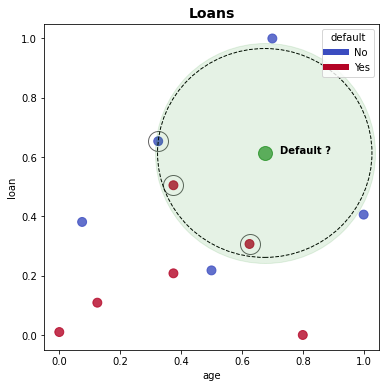

,age,loan,default,distance
2,0.625,0.306931,1,0.310977
4,0.375,0.504950,1,0.319158
10,0.325,0.653465,0,0.352234


In [254]:
dist = DistanceMetric.get_metric('euclidean')
d = dist.pairwise(loans_scaled[['age','loan']],case_scaled[['age','loan']])

loans_scaled['distance'] = d

k3_neighbors_scaled = loans_scaled.nsmallest(3,'distance')

f, ax = plt.subplots(1,1,figsize=(6,6))
cmap_data = plt.cm.coolwarm 

ax.plot(case_scaled.age, case_scaled.loan, 'go', markersize=220, alpha=0.10)
ax.scatter(k3_neighbors_scaled.age, k3_neighbors_scaled.loan, edgecolors='k', c='w', alpha=0.6, s=400)
ax.scatter(loans_scaled.age, loans_scaled.loan, c=loans_scaled.default, cmap=cmap_data, alpha=0.8, s=80)
ax.plot(case_scaled.age, case_scaled.loan, 'go', markersize=14, alpha=0.6)

a_circle = plt.Circle((case_scaled.age, case_scaled.loan), k3_neighbors_scaled.distance.max(), edgecolor='k', linestyle='dashed',fill=False)
ax.add_artist(a_circle)

plt.text(case_scaled.age+0.05, case_scaled.loan,'Default ?', weight='bold')
plt.title('Loans',weight='bold',fontsize=14)
plt.xlabel("age")
plt.ylabel("loan")

custom_lines = [Line2D([0], [0], color=cmap_data(0.), lw=6),
                Line2D([0], [0], color=cmap_data(1.), lw=6)]
plt.legend(custom_lines, ['No', 'Yes'], loc='upper right',title='default')

plt.show()

display(k3_neighbors_scaled)

Como você pode ver o resultado agora é outro e a classe prevista do empréstimo será *Default Yes* (zeros), com probabilidade de $2/3$ e, portanto, não deveríamos conceder esse empréstimo.  

# Knn `scikit-learn` 

Vamos empregar agora o estimador `KNeighborsClassifier` do `scikit-learn` para o mesmo problema acima. O modo de uso do estimador é o mesmo que empregamos para o classificador logístico e será empregado em todos os demais modelos supervisionados que iremos implementar.

In [255]:
from sklearn import neighbors
from sklearn.preprocessing import MinMaxScaler

X = loans[['age','loan']]      
y = loans.default   

scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X) 
case_scaled = scaler.transform(case)

clf = neighbors.KNeighborsClassifier(n_neighbors = 3)

clf.fit(X, y)                 

y_pred = clf.predict(case_scaled)

default_pred = ['No','Yes'][y_pred[0]]
print('Default? ', default_pred)

Default?  Yes


# CASO: 10 year risk of coronary heart disease CHD

Vamos agora empregar os mesmos dados que empregamos antes com o classificador logístico e aplicar um modelo de K-Vizinhos Mais Próximos.


In [256]:
df = pd.read_csv('https://raw.githubusercontent.com/TarekDib03/Analytics/master/Week3%20-%20Logistic%20Regression/Data/framingham.csv')
df.head()

,male,age,education,currentSmoker,cigsPerDay,BPMeds,prevalentStroke,prevalentHyp,diabetes,totChol,sysBP,diaBP,BMI,heartRate,glucose,TenYearCHD
0,1,39,4.0,0,0.0,0.0,0,0,0,195.0,106.0,70.0,26.97,80.0,77.0,0
1,0,46,2.0,0,0.0,0.0,0,0,0,250.0,121.0,81.0,28.73,95.0,76.0,0
2,1,48,1.0,1,20.0,0.0,0,0,0,245.0,127.5,80.0,25.34,75.0,70.0,0
3,0,61,3.0,1,30.0,0.0,0,1,0,225.0,150.0,95.0,28.58,65.0,103.0,1
4,0,46,3.0,1,23.0,0.0,0,0,0,285.0,130.0,84.0,23.10,85.0,85.0,0


## Preparação dos Dados



Vamos, como antes, simplesmente excluir os dados ausentes.

In [257]:
print('Before',len(df))
df = df.dropna()
print('After',len(df))

Before 4240
After 3658


## Aplicando o Modelo Knn

Vamos agora aplicar um modelo Knn, k=3, e comparar os resultados com o classificador logístico. 

> **Antes de prosseguir note a semelhança das implementações dos estimadores de classificação do scikit-learn. Eles seguem a mesma estrutura, e são semelhantes também ao estimadores de regressão embora lá não tenhamos empregado a separação de conjuntos de treinamento e teste que funcionam de modo diferente. Basicamente, além dos imports, apenas a definição do estimador precisa ser alterada.** 



```
#-------------------------------------------------------------------------------
# Implementação do Modelo logístico
#-------------------------------------------------------------------------------
```
## `from sklearn.linear_model import LogisticRegression` 
```
from sklearn.model_selection import train_test_split

X = df.drop(columns=['TenYearCHD'])
y = df.TenYearCHD

X_train, X_test, y_train, y_test = \
train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

```
## `clf = LogisticRegression(max_iter=10000)`
```
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print( y_pred[0:10], '...' )
print( f'{clf.score(X_test,y_test):.2f}' )
```

```
#-------------------------------------------------------------------------------
# Implementação do Modelo Knn
#-------------------------------------------------------------------------------
```
## `from sklearn.neighbors import KNeighborsClassifier` 
```
from sklearn.model_selection import train_test_split

X = df.drop(columns=['TenYearCHD'])
y = df.TenYearCHD

X_train, X_test, y_train, y_test = \
train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

```
## `clf = KNeighborsClassifier(n_neighbors=3)`
```
clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print( y_pred[0:10], '...' )
print( f'{clf.score(X_test,y_test):.2f}' )
```

O esquema acima é bastante simples mas ainda pode ser necessário incluir preparações dos dados para uso nos modelos. No caso, veja que concluímos que no caso do Knn é importante aplicarmos a normalização das variáveis preditoras `X`. Isso precisa, então, ser incluído no seu código (note, isso poderia ser omitido se você transformasse os dados originais para então atribuir à `X`).

In [279]:
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split

X = df.drop(columns=['TenYearCHD'])
scaler = MinMaxScaler()
scaler.fit(X)
X = scaler.transform(X) 
y = df.TenYearCHD

X_train, X_test, y_train, y_test = \
train_test_split(X, y, stratify=y, test_size=0.3, random_state=123)

clf = KNeighborsClassifier(n_neighbors = 3)

clf.fit(X_train,y_train)

y_pred = clf.predict(X_test)

print( y_pred[0:10], '...' )
print( f'{clf.score(X_test,y_test):.2f}' )

[0 0 1 0 0 0 0 0 1 0] ...
0.82


In [278]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

cm = confusion_matrix(y_test, y_pred)
print('\nMatriz de Confusão:\n')
print(cm)
    
accuracy = accuracy_score(y_test, y_pred)
print('\nScore de Acuracidade (1):\n')
print(f'{accuracy:.2f}')

accuracy = clf.score(X_test, y_test)
print('\nScore de Acuracidade (2):\n')
print(f'{accuracy:.2f}')

print('\nClassification Report:\n')
print(classification_report(y_test, y_pred))


Matriz de Confusão:

[[876  55]
 [141  26]]

Score de Acuracidade (1):

0.82

Score de Acuracidade (2):

0.82

Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.94      0.90       931
           1       0.32      0.16      0.21       167

    accuracy                           0.82      1098
   macro avg       0.59      0.55      0.55      1098
weighted avg       0.78      0.82      0.79      1098



## Análise

Embora com uma acuracidade um pouco menor que a obtida no modelo logístico o modelo de K-Vizinhos, com k=3, apresenta um resultado mas balanceado entre as classes e poderíamos sugerir empregar este modelo como um modelo mais adequado. 

Essa análise, entretanto, não é definitiva e estamos, por hora, apenas explorando como diferentes modelos podem levar a resultados diferentes e como compará-los. Nossa jornada para escolha de melhores modelos está apenas começando e isso está longe de ser uma tarefa simples.

## Predição de Novos Casos

Se considerarmos 0.82 um bom resultado e esse um bom modelos podemos então aplicar o modelo para novos casos do mesmo modo que fizemos antes com o classificador logístico (aula anterior). Por exemplo, podemos fazer predição para pacientes homens e mulheres hipotéticos em que todos os indicadores estejam no percentil 0.75.

> **Você deve notar agora que, como fizemos uma transformação dos dados das variáveis preditoras precisamos aplicar esta mesma transformação (a normalização!) nos valores dos novos casos. Como empregamos um estimador `scaler`, podemos empregar essa mesma transformação e você pode notar também que, se não tivessemos empregado um estimador, não saberíamos como aplicar a mesma transformação! Essa a vantagem de empregarmos um estimador para isso!**

In [286]:
X_new = pd.DataFrame( df.drop(columns=['TenYearCHD']).groupby('male').quantile(0.75) ).reset_index()

X_new = scaler.transform(X_new)
X_new


array([[0.        , 0.63157895, 0.66666667, 1.        , 0.14285714,
        0.        , 0.        , 1.        , 0.        , 0.31827515,
        0.29550827, 0.43386243, 0.2949588 , 0.41414141, 0.1299435 ],
       [1.        , 0.63157895, 0.66666667, 1.        , 0.28571429,
        0.        , 0.        , 1.        , 0.        , 0.29979466,
        0.27186761, 0.44444444, 0.30925836, 0.36363636, 0.13276836]])

In [287]:
clf.predict(X_new)

array([0, 0])

Como no modelo logístico esses pacientes não apresentam risco segundo nosso modelo e você pode verificar outros percentis, como o percentil 0.9 em que já estimamos o risco para pacientes do sexo masculino.

In [288]:
X_new = pd.DataFrame( df.drop(columns=['TenYearCHD']).groupby('male').quantile(0.90) ).reset_index()

X_new = scaler.transform(X_new)
clf.predict(X_new)

array([0, 1])

# Métricas de Distância

Para medir a distância entre vetores característicos, os elementos mais próximos, empregamos até aqui a distância Euclidiana. Ela é a distância mais comum, mas existem várias funções distância que podem ser aplicadas, não só aqui mas também em outros modelos (*knn*, *kmeans* etc.). Embora a distância euclidiana pareça ser a mais aplicada, outras funções distância encontram mais uso em contextos específicos como a distância de **Hamming** para dados binários e cadeias de strings ou a distância **Coseno** para análise de dados de linguagem natural, textos e documentos. 

Uma função é uma função distância se atende 4 propriedades:

$i. d(x,y) \ge 0$

$ii. d(x,x) = 0$

$iii. d(x,y) = d(y,x)$

$iv.  d(x,y) \le d(x,z) + d(z,y)$



## Algumas funções distância comuns

Distância Euclidiana $\qquad \qquad \qquad \qquad \qquad \qquad$ ${\displaystyle \| ab \| _ {2} = {\sqrt {\sum _ {i} (a_ {i} -b_ {i}) ^ {2}}}}$ 

Distância Euclidiana Quadrática $\qquad \qquad \qquad \qquad$  ${\displaystyle \| ab \| _ {2} ^ {2} = \sum _ {i} (a_ {i} -b_ {i}) ^ {2}} $

Distância de Manhattan $\qquad \qquad \qquad\qquad \qquad$ ${\displaystyle \| ab \| _ {1} = \sum _ {i} | a_ {i} -b_ {i} |}$

Distância Máxima $\qquad \qquad \qquad \qquad \qquad\qquad$  ${\displaystyle \| ab \| _ {\infty} = \max _ {i} | a_ {i} -b_ {i} |}$

Distância Minkowski $\qquad \qquad \qquad \qquad \qquad \qquad$ ${\displaystyle \| ab \| _ {Minkowski} = {(\sum _ {i} |a_ {i} -b_ {i}| ^ {p}})^{\frac{1}{p}}}$ 







## Distância de Hamming para Strings

A distância de Hamming tem aplicação para cadeias de símbolos de mesmo comprimento e, por exemplo, pode ser empregada para medir a distância entre cadeias de DNA.





In [ ]:
def hamming_distance(string1, string2):
	dist_counter = 0
	for n in range(len(string1)):
		if string1[n] != string2[n]:
			dist_counter += 1
	return dist_counter

hamming_distance('ACGTACGT','ACGTTACG')

4

In [ ]:
def hamming_distance2(string1, string2):
  return sum(xi != yi for xi, yi in zip(string1, string2))

hamming_distance2('ACGTACGT','ACGTTACG')

4

## Distância Cosseno

A Distância Cosseno encontra aplicação no tratamento de  textos em que os textos têm uma representação vetorial baseada na frequência dos termos (ou palavras) como as representações *bow*, *tf-idf* etc. Ela mede o ângulo formado pelos vetores e a distância de dois vetores $a$ e $b$ pode ser obtida a partir da expressão:

$$ a b^t  = \|a\| \|b\| cos(\theta)$$

Definimos a *similaridade* de dois vetores como:

$$ similarity(a,b) = cos(\theta) = \frac{a b^t }{\|a\| \|b\|} = \frac{ \sum\limits_{i=1}^{n}{a_i  b_i} }{ \sqrt{\sum\limits_{i=1}^{n}{a_i^2}}  \sqrt{\sum\limits_{i=1}^{n}{b_i^2}} }$$

E a distância:

$$ distance(a,b) = 1 - similarity(a,b)$$


Você pode verificar aqui https://scikit-learn.org/stable/modules/generated/sklearn.metrics.DistanceMetric.html#sklearn.metrics.DistanceMetric várias métricas possíveis de serem empregadas no scikit-learn, e empregá-las no código de implementação do Knn verificando os resultados.

# Seleção de Hiperparâmetros

Em todos exemplos anteriores empregamos o modelo Knn com k=3 e a função de distância euclidiana. Será que haveriam *hiperparâmetros* melhores com desempenho melhor? 

A escolha de melhores *hiperparâmetros* é em geral por experimentação uma vez que não existem hiperparâmetros melhores *apriori* para quaisquer conjuntos de dados. A ideia, então, é criarmos os diferentes modelos e avaliarmos o desempenho (as métricas que você aprendeu aqui!) de cada um para obtermos os melhores hiperparâmetros. 

Podemos então adaptar o nosso código do modelo Knn anterior para, por exemplo, variar os hiperparâmetros k, no range de valores de 2 a 10 e experimentar o resultado das funções distância 'euclidean' e 'manhattan'... mas isso eu vou deixar para você.

# Sumário da Aula

Nesta aula você conheceu novas Métricas de Classificação como **Precisão, Revocação, F1 e a Matriz de Confusão** que são bastante importantes e empregadas tanto para comparar e selecionar modelos, como para o ajuste do hiperparâmetros de um mesmo modelo. 

Ainda existem muitas outras técnicas e métricas envolvendo o desempenho dos modelos como a curva ROC (Receiver Operating Characteristic Curve), uso da validação cruzada (Cross Validation), Curva de Aprendizado ou Regularização. De qualquer modo a avaliação e obtenção de desempenho dos modelos não é uma tarefa fácil e trataremos em algumas dessas técnicas nas aula seguintes. 

Você também aprendeu aqui como funciona e como implementar um modelo de **K-Vizinhos mais Próximos para Classificação**, aprendendo ainda como quando e como empregar a **normalização** de dados com estimadores e outras **métricas de distância** que podem ser empregadas. Esses conceitos são importantes pois podem ser aplicados a muitos outros modelos como você verá a seguir.






# Para Saber Mais


* Quer conhecer outras métricas obtidas a partir da Matriz de Confusão? São dezenas... rs. Acesse então **Precision and Recall** https://en.wikipedia.org/wiki/Precision_and_recall e **Confusion Matrix** https://en.wikipedia.org/wiki/Confusion_matrix e aproveite para ver outras referências nessas páginas.

* Você saberia aplicar os conceitos de Precisão e Recall quando temos mais de duas classes para a variável objetivo? Pense um pouco, essa não é uma pergunta simples. Depois acesse **Computing Precision and Recall for Multi-Class Classification Problems** http://text-analytics101.rxnlp.com/2014/10/computing-precision-and-recall-for.html. 

* Mas para saber mais o melhor mesmo é praticar. Você pode adaptar o código do modelo Knn anterior para, por exemplo, variar os hiperparâmetros k, no range de valores de 2 a 10 e ainda experimentar o resultado de diferentes funções distância 'euclidean' e 'manhattan'. Salve os resultados de cada modelo e verifique, quais os melhores *hiper*parâmetros você encontra?

* **Quando normalizar e quando não normalizar?**. De um modo simples, dados são normalizados ou redimensionados para trazer todas as variáveis ​​em proporção umas com as outras. Existem diferentes formas de normalização e redimensionamento de dados e aqui aplicamos apenas uma delas. Acesse o artigo **When to perform a Feature Scaling?** de Raghav Vashisht, disponível em: https://www.atoti.io/when-to-perform-a-feature-scaling/ para saber mais sobre isso e veja também **Compare the effect of different scalers on data with outliers** disponível em: https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html para conhecer outros estimadores de normalização do `scikit-learn`. 

# Referências

* Sayad, Saed (2021). **An Introduction to Data Science**, 
Disponível em: https://www.saedsayad.com/data_mining_map.htm Acesso: 31 de Março de 2022.

* Larose, Chantal D.; Larose, Daniel T. **Data Science Using Python and R** Hoboken: Wiley, c2019. E-book (259 p.) (Wiley Series on Methods and Applications in Data Mining Ser.). ISBN 9781119526834 (electronic bk.). Disponível em: https://www3.mackenzie.br/biblioteca_virtual/index.php?tipoBiblio=ebookcentral&flashObg=n

* Kotu, Vijay; Deshpande, Balachandre **Data Science: concepts and practice**. 2nd ed. Cambridge, [England]: Morgan Kaufmann, c2019. E-book (570 p.) ISBN 9780128147627 (electronic bk.). Disponível em: http://pergamum.mackenzie.br:8080/pergamumweb/vinculos/00003c/00003cef.jpg.

* Jake VanderPlas. **Python Data Science Handbook**  O'Reilly Media, Inc. (2016). ISBN: 9781491912058. Disponível em: https://jakevdp.github.io/PythonDataScienceHandbook/. Acesso: 31 de Março de 2022.

* ___. **An introduction to machine learning with scikit-learn** Disponível em: https://scikit-learn.org/stable/tutorial/basic/tutorial.html Acesso: 31 de Março de 2022.

* ___. **scikit-learn: machine learning in Python** Disponível em: http://scipy-lectures.org/packages/scikit-learn/index.html Acesso: 31 de Março de 2022.